<a href="https://colab.research.google.com/github/tirenton/Algorithm-trading/blob/main/Project_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance pandas numpy scipy matplotlib PyPortfolioOpt
!backtrader
!--upgrade backtrader
!PyPortfolioOpt

[*********************100%***********************]  5 of 5 completed
[*********************100%***********************]  5 of 5 completed


Final Portfolio Value: $126394.36


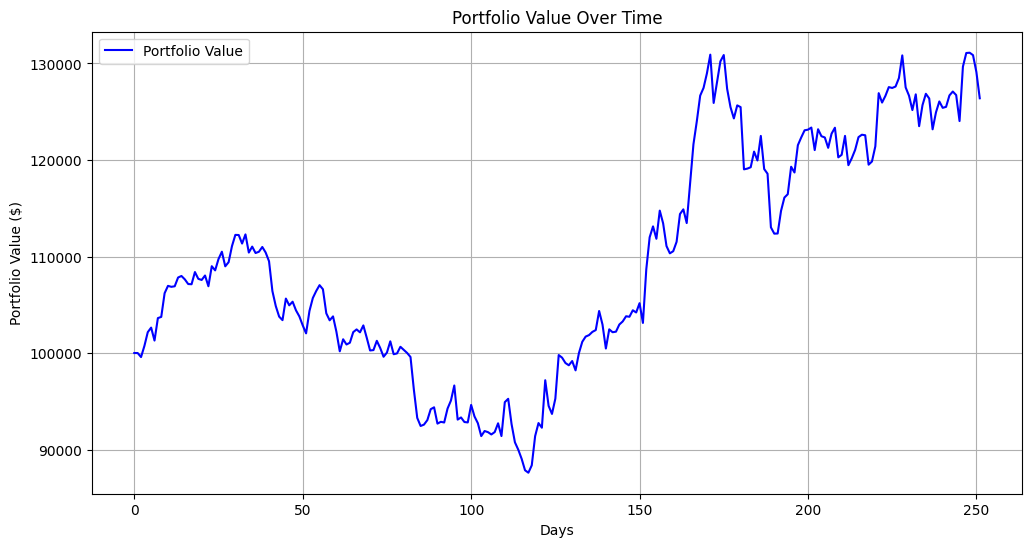

In [3]:
import backtrader as bt
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from pypfopt import risk_models, EfficientFrontier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Define strategy class
class RandomForestStrategy(bt.Strategy):
    params = (
        ("rebalance_threshold", 0.05),  # 5% deviation threshold
        ("n_estimators", 100),           # Number of trees in the forest
        ("random_state", 42),            # Random seed for reproducibility
    )

    def __init__(self, optimized_weights):
        self.weights = optimized_weights  # Use pre-optimized weights from the training period
        self.model = RandomForestRegressor(n_estimators=self.params.n_estimators, random_state=self.params.random_state)
        self.portfolio_values = []  # Store portfolio values for plotting

    def next(self):
        current_weights = self.get_portfolio_weights()  # Get current portfolio weights

        # Record the current portfolio value
        self.portfolio_values.append(self.broker.getvalue())

        # Check if any asset deviates from its target weight by more than the threshold
        for i, target_weight in enumerate(self.weights):
            if abs(current_weights[i] - target_weight) > self.params.rebalance_threshold:
                self.rebalance_portfolio()
                break  # Rebalance after the first detected deviation

    def get_portfolio_weights(self):
        """Calculate the current portfolio weights as percentages."""
        weights = []
        total_value = self.broker.getvalue()

        for d in self.datas:
            position_value = self.getposition(d).size * d.close[0]  # Current position value
            weights.append(position_value / total_value)

        return weights

    def rebalance_portfolio(self):
        """Rebalance portfolio according to the optimized weights."""
        for i, d in enumerate(self.datas):
            target_weight = self.weights[i] if i < len(self.weights) else 0
            self.order_target_percent(data=d, target=target_weight)

# Function to create features for Random Forest model
def create_features(data):
    features = pd.DataFrame(index=data.index)
    for ticker in data.columns:
        features[f'{ticker}_returns'] = data[ticker].pct_change()
        features[f'{ticker}_lag1'] = data[ticker].shift(1)
        features[f'{ticker}_lag2'] = data[ticker].shift(2)
        features[f'{ticker}_volatility'] = data[ticker].rolling(window=5).std()
    features.dropna(inplace=True)  # Remove rows with NaN values
    return features

# Function to optimize portfolio weights using Random Forest predictions
def optimize_weights(train_data, tickers):
    features = create_features(train_data)

    # Prepare target variable (future returns)
    targets = features[[f'{ticker}_returns' for ticker in tickers]].shift(-1).dropna()  # Shift to get future returns
    features = features[:-1]  # Align features with targets

    # Train the Random Forest model
    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Predict future returns
    predicted_returns = model.predict(X_test)

    # Calculate optimal weights using Efficient Frontier
    ef = EfficientFrontier(predicted_returns.mean(axis=0), risk_models.sample_cov(train_data))  # Use sample covariance
    weights_dict = ef.max_sharpe(risk_free_rate=0)  # Set risk-free rate to 0

    # Convert the weights to a list, ensuring an entry for each asset
    optimized_weights = [weights_dict.get(ticker, 0) for ticker in tickers]
    return optimized_weights

# Run backtest function for the testing period
def run_backtest(test_data, strategy, optimized_weights):
    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(100000)  # Initial capital

    # Add testing data to Cerebro
    for symbol in test_data.columns:
        df = pd.DataFrame({'close': test_data[symbol]})
        df['open'] = df['high'] = df['low'] = df['close']  # Duplicate close for OHLC
        df.index = test_data.index  # Ensure that the index is the datetime index
        bt_data = bt.feeds.PandasData(dataname=df)
        cerebro.adddata(bt_data, name=symbol)

    # Add strategy to Cerebro with the optimized weights
    cerebro.addstrategy(strategy, optimized_weights=optimized_weights)

    # Run the backtest
    cerebro.run()
    final_value = cerebro.broker.getvalue()
    print(f"Final Portfolio Value: ${final_value:.2f}")

    # Get portfolio values for plotting
    portfolio_values = cerebro.runstrats[0][0].portfolio_values

    return portfolio_values

# Main function to split data into training and testing sets and run the backtest
def train_and_test(train_data, test_data):
    tickers = train_data.columns.tolist()  # Get tickers from training data
    optimized_weights = optimize_weights(train_data, tickers)
    portfolio_values = run_backtest(test_data, RandomForestStrategy, optimized_weights)

    return portfolio_values

# Function to download data from Yahoo Finance
def download_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)
    return data['Adj Close']  # Return adjusted close prices

# Function to plot portfolio value
def plot_portfolio_value(portfolio_values):
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value', color='blue')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage for downloading data and training/testing
if __name__ == "__main__":
    tickers = ["AAPL", "AMZN", "NFLX", "GOOGL", "TSLA"]  # Define your tickers here
    train_start = '2018-11-01'
    train_end = '2023-11-01'
    test_start = '2023-11-01'
    test_end = '2024-11-01'

    # Download training and testing data
    train_data = download_data(tickers, train_start, train_end)
    test_data = download_data(tickers, test_start, test_end)

    # Train the model and test it
    portfolio_values = train_and_test(train_data, test_data)

    # Plot the portfolio value
    plot_portfolio_value(portfolio_values)


[*********************100%***********************]  5 of 5 completed


Final Portfolio Value for this month: $126826.02


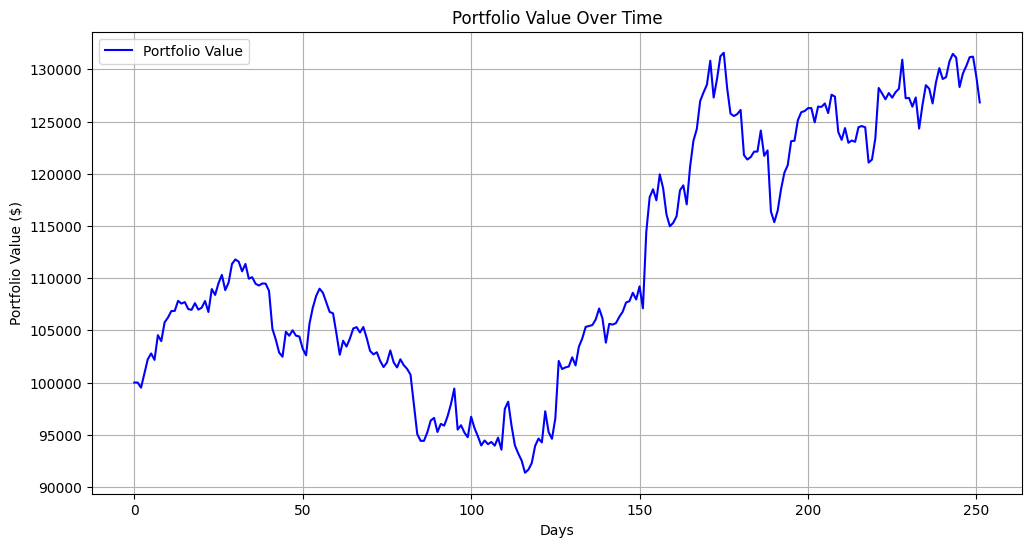

In [4]:
import backtrader as bt
import pandas as pd
import numpy as np
import yfinance as yf
from sklearn.ensemble import RandomForestRegressor
from pypfopt import risk_models, EfficientFrontier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from dateutil.relativedelta import relativedelta
import pytz

# Define strategy class
class RandomForestStrategy(bt.Strategy):
    params = (
        ("rebalance_threshold", 0.05),  # 5% deviation threshold
        ("n_estimators", 100),           # Number of trees in the forest
        ("random_state", 42),            # Random seed for reproducibility
    )

    def __init__(self, optimized_weights):
        self.weights = optimized_weights  # Use pre-optimized weights from the training period
        self.model = RandomForestRegressor(n_estimators=self.params.n_estimators, random_state=self.params.random_state)
        self.portfolio_values = []  # Store portfolio values for plotting

    def next(self):
        current_weights = self.get_portfolio_weights()  # Get current portfolio weights
        self.portfolio_values.append(self.broker.getvalue())  # Record the current portfolio value

        for i, target_weight in enumerate(self.weights):
            if abs(current_weights[i] - target_weight) > self.params.rebalance_threshold:
                self.rebalance_portfolio()
                break  # Rebalance after the first detected deviation

    def get_portfolio_weights(self):
        weights = []
        total_value = self.broker.getvalue()

        for d in self.datas:
            position_value = self.getposition(d).size * d.close[0]
            weights.append(position_value / total_value)

        return weights

    def rebalance_portfolio(self):
        for i, d in enumerate(self.datas):
            target_weight = self.weights[i] if i < len(self.weights) else 0
            self.order_target_percent(data=d, target=target_weight)

# Function to create features for Random Forest model
def create_features(data):
    features = pd.DataFrame(index=data.index)
    for ticker in data.columns:
        features[f'{ticker}_returns'] = data[ticker].pct_change()
        features[f'{ticker}_lag1'] = data[ticker].shift(1)
        features[f'{ticker}_lag2'] = data[ticker].shift(2)
        features[f'{ticker}_volatility'] = data[ticker].rolling(window=5).std()
    features.dropna(inplace=True)
    return features

# Function to optimize portfolio weights using Random Forest predictions
def optimize_weights(train_data, tickers):
    features = create_features(train_data)

    targets = features[[f'{ticker}_returns' for ticker in tickers]].shift(-1).dropna()
    features = features[:-1]

    X_train, X_test, y_train, y_test = train_test_split(features, targets, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    predicted_returns = model.predict(X_test)

    ef = EfficientFrontier(predicted_returns.mean(axis=0), risk_models.sample_cov(train_data))
    weights_dict = ef.max_sharpe(risk_free_rate=0)
    optimized_weights = [weights_dict.get(ticker, 0) for ticker in tickers]
    return optimized_weights

# Run backtest function for the testing period
def run_backtest(test_data, strategy, optimized_weights):
    cerebro = bt.Cerebro()
    cerebro.broker.set_cash(100000)

    for symbol in test_data.columns:
        df = pd.DataFrame({'close': test_data[symbol]})
        df['open'] = df['high'] = df['low'] = df['close']
        df.index = test_data.index
        bt_data = bt.feeds.PandasData(dataname=df)
        cerebro.adddata(bt_data, name=symbol)

    cerebro.addstrategy(strategy, optimized_weights=optimized_weights)

    cerebro.run()
    final_value = cerebro.broker.getvalue()
    print(f"Final Portfolio Value for this month: ${final_value:.2f}")

    portfolio_values = cerebro.runstrats[0][0].portfolio_values
    return portfolio_values

# Main function to split data into training and testing sets and run the backtest
def train_and_test(train_data, test_data, tickers):
    optimized_weights = optimize_weights(train_data, tickers)
    portfolio_values = run_backtest(test_data, RandomForestStrategy, optimized_weights)
    return portfolio_values

# Function to download data from Yahoo Finance
def download_data(tickers, start, end):
    data = yf.download(tickers, start=start, end=end)
    return data['Adj Close']

# Function to plot portfolio value
def plot_portfolio_value(portfolio_values):
    plt.figure(figsize=(12, 6))
    plt.plot(portfolio_values, label='Portfolio Value', color='blue')
    plt.title('Portfolio Value Over Time')
    plt.xlabel('Days')
    plt.ylabel('Portfolio Value ($)')
    plt.legend()
    plt.grid()
    plt.show()

# Example usage for downloading data and training/testing
if __name__ == "__main__":
    tickers = ["AAPL", "AMZN", "NFLX", "GOOGL", "TSLA"]
    initial_train_start = '2018-11-01'
    initial_train_end = '2023-11-01'
    final_test = '2024-11-01'

    train_start = pd.to_datetime(initial_train_start).tz_localize('UTC')
    train_end = pd.to_datetime(initial_train_end).tz_localize('UTC')
    test_start = train_end
    test_end = train_end + relativedelta(years=1)
    final_test = pd.to_datetime(final_test).tz_localize('UTC')

    full_data = download_data(tickers, '2018-11-01', '2024-11-01')

    month = 0
    while test_end <= final_test:
        train_data = full_data.loc[train_start:train_end]
        test_data = full_data.loc[test_start:test_end]

        portfolio_values = train_and_test(train_data, test_data, tickers)

        plot_portfolio_value(portfolio_values)

        train_start += relativedelta(months=1)
        train_end += relativedelta(months=1)
        test_start += relativedelta(months=1)
        test_end += relativedelta(months=1)
        month += 1
